# Kaggle: house prices
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

## Import packages

In [36]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from scipy.stats.stats import skew
from scipy.stats.stats import pearsonr

## Import data

In [37]:
# Test and training set
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# Combine into one dataset for the purposes of cleaning, and make sure that index continues
data_full = pd.concat([train, test], keys = ['train', 'test'])#ignore_index = True)

In [38]:
# What does the dataset look like?
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


## Data cleansing

### Dealing with nulls

In [39]:
# Count the uniques for each column for a given dataframe
def df_uniques(df):
    print('Col name,', 'Number of nulls,', 'Number of unique values', '% of nulls')
    list_of_features = []
    for col in df:
        l = [col, df[col].shape[0] - df[col].count(), df[col].unique().shape[0], '%.3f' %((df[col].shape[0] - df[col].count()) / df[col].shape[0])]
        list_of_features.append(l)
    # Sort by the number of NULLs: 
    list_of_features = sorted(list_of_features, key = lambda x: x[1], reverse = True)
    return list_of_features

df_uniques(train)

Col name, Number of nulls, Number of unique values % of nulls


[['PoolQC', 1453, 4, '0.995'],
 ['MiscFeature', 1406, 5, '0.963'],
 ['Alley', 1369, 3, '0.938'],
 ['Fence', 1179, 5, '0.808'],
 ['FireplaceQu', 690, 6, '0.473'],
 ['LotFrontage', 259, 111, '0.177'],
 ['GarageType', 81, 7, '0.055'],
 ['GarageYrBlt', 81, 98, '0.055'],
 ['GarageFinish', 81, 4, '0.055'],
 ['GarageQual', 81, 6, '0.055'],
 ['GarageCond', 81, 6, '0.055'],
 ['BsmtExposure', 38, 5, '0.026'],
 ['BsmtFinType2', 38, 7, '0.026'],
 ['BsmtQual', 37, 5, '0.025'],
 ['BsmtCond', 37, 5, '0.025'],
 ['BsmtFinType1', 37, 7, '0.025'],
 ['MasVnrType', 8, 5, '0.005'],
 ['MasVnrArea', 8, 328, '0.005'],
 ['Electrical', 1, 6, '0.001'],
 ['Id', 0, 1460, '0.000'],
 ['MSSubClass', 0, 15, '0.000'],
 ['MSZoning', 0, 5, '0.000'],
 ['LotArea', 0, 1073, '0.000'],
 ['Street', 0, 2, '0.000'],
 ['LotShape', 0, 4, '0.000'],
 ['LandContour', 0, 4, '0.000'],
 ['Utilities', 0, 2, '0.000'],
 ['LotConfig', 0, 5, '0.000'],
 ['LandSlope', 0, 3, '0.000'],
 ['Neighborhood', 0, 25, '0.000'],
 ['Condition1', 0, 9, '0.0

In [40]:
# The following features have a crazy number of nulls 
# PoolQC, MiscFeature, Alley, Fence, FireplaceQu, LotFrontage 

# From looking at the data dictionary, these NAs are not necessarily a problem - but "NA" or nUll is misleading, so let's replace them
# Alley: NA = no alley -> replace with "None"
# MiscFeature: other features (e.g. tennis court) - NA = no other feature -> replace with "None"
# Fence: NA = no fence -> replace with "None"
# FireplaceQu: you guessed it -> replace with "None"

In [41]:
# Let's get a neat list of the null columns - need to combine both datasets for this
null_columns = [col for col in data_full.columns if data_full[col].isnull().any()]
print(null_columns)

['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'KitchenQual', 'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscFeature', 'PoolQC', 'SalePrice', 'SaleType', 'TotalBsmtSF', 'Utilities']


In [42]:
# Define a function to replace nulls for many columns: 
def fill_nulls(df, col_list, na_val):
    for col in col_list:
        df[col].fillna(value = na_val, inplace = True)
    return df

In [43]:
# Categorical fields with an obvious meaning NA -> 'None'
nulls_to_none = ['PoolQC', 'Fence', 'MiscFeature', 'Alley', 'FireplaceQu', 'MasVnrType', 'BsmtCond', 
                 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish', 
                 'GarageQual', 'GarageCond', 'KitchenQual']
# Numerical fields with an obvious meaning NA -> 0
nulls_to_zero = ['LotFrontage', 'MasVnrArea', 'BsmtQual', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 
                 'BsmtHalfBath', 'BsmtUnfSF', 'GarageArea', 'GarageCars', 'TotalBsmtSF']

# Categorical fields with a less obvious interpretation - guessing that NA means 'None' (there are very few anyway)
nulls_to_zero_2 = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd']
nulls_to_other = ['SaleType', 'Functional']

# Apply to both test and training sets:
for df in [train, test]: 
    fill_nulls(df, nulls_to_none, 'None')
    fill_nulls(df, nulls_to_zero, 0)
    fill_nulls(df, nulls_to_zero_2, 0)
    fill_nulls(df, nulls_to_other, 'Other')
# NB we still have 'data_full' which has not been updated yet

In [44]:
# Add more here about infilling with median values for some fields....

### Data types
Let's make sure everything is in the correct data type.  Pandas will have a go at importing things correctly, but this is good practice to make sure that things haven't gone awry. Ultimately we'll want to use dummy variables for categorical data anyway.

In [45]:
# Print out data types
def data_types(df):
    for col in df:
        print(col, type(df[col][1]))   

In [46]:
data_types(train)

Id <class 'numpy.int64'>
MSSubClass <class 'numpy.int64'>
MSZoning <class 'str'>
LotFrontage <class 'numpy.float64'>
LotArea <class 'numpy.int64'>
Street <class 'str'>
Alley <class 'str'>
LotShape <class 'str'>
LandContour <class 'str'>
Utilities <class 'str'>
LotConfig <class 'str'>
LandSlope <class 'str'>
Neighborhood <class 'str'>
Condition1 <class 'str'>
Condition2 <class 'str'>
BldgType <class 'str'>
HouseStyle <class 'str'>
OverallQual <class 'numpy.int64'>
OverallCond <class 'numpy.int64'>
YearBuilt <class 'numpy.int64'>
YearRemodAdd <class 'numpy.int64'>
RoofStyle <class 'str'>
RoofMatl <class 'str'>
Exterior1st <class 'str'>
Exterior2nd <class 'str'>
MasVnrType <class 'str'>
MasVnrArea <class 'numpy.float64'>
ExterQual <class 'str'>
ExterCond <class 'str'>
Foundation <class 'str'>
BsmtQual <class 'str'>
BsmtCond <class 'str'>
BsmtExposure <class 'str'>
BsmtFinType1 <class 'str'>
BsmtFinSF1 <class 'numpy.int64'>
BsmtFinType2 <class 'str'>
BsmtFinSF2 <class 'numpy.int64'>
BsmtUn

In [47]:
# By pasting the above list into a spreadsheet and cross checking with the data dictionary, we can 
# see which category each field should be

# Makes lists of each type
categories = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
              'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 
              'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 
              'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType2', 'Heating', 
              'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 
              'GarageFinish', 'GarageCars', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 
              'SaleCondition']
floats = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
          '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
          'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

ints = ['OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 
         'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces']

bools = ['CentralAir']

# Define a function for converting a list of columns to a particular type: 
def convert_col_type(df, cols, type):
    for col in cols:
        df[col] = df[col].astype(type)

In [48]:
# Convert each column for both test and training sets:
for df in [train, test]:
    convert_col_type(df, categories, 'category')
    convert_col_type(df, floats, 'float')
    convert_col_type(df, ints, 'int')
    convert_col_type(df, bools, 'bool')
    
# Re-define the full dataset
data_full = pd.concat([train, test], keys = ['train', 'test'])

In [49]:
# Print out data types
def data_types(df):
    for col in df:
        print(col, type(df[col][1]))   
data_types(train)

Id <class 'numpy.int64'>
MSSubClass <class 'numpy.int64'>
MSZoning <class 'str'>
LotFrontage <class 'numpy.float64'>
LotArea <class 'numpy.float64'>
Street <class 'str'>
Alley <class 'str'>
LotShape <class 'str'>
LandContour <class 'str'>
Utilities <class 'str'>
LotConfig <class 'str'>
LandSlope <class 'str'>
Neighborhood <class 'str'>
Condition1 <class 'str'>
Condition2 <class 'str'>
BldgType <class 'str'>
HouseStyle <class 'str'>
OverallQual <class 'numpy.int64'>
OverallCond <class 'numpy.int64'>
YearBuilt <class 'numpy.int64'>
YearRemodAdd <class 'numpy.int64'>
RoofStyle <class 'str'>
RoofMatl <class 'str'>
Exterior1st <class 'str'>
Exterior2nd <class 'str'>
MasVnrType <class 'str'>
MasVnrArea <class 'numpy.float64'>
ExterQual <class 'str'>
ExterCond <class 'str'>
Foundation <class 'str'>
BsmtQual <class 'str'>
BsmtCond <class 'str'>
BsmtExposure <class 'str'>
BsmtFinType1 <class 'str'>
BsmtFinSF1 <class 'numpy.float64'>
BsmtFinType2 <class 'str'>
BsmtFinSF2 <class 'numpy.float64'>


## Motivating plots

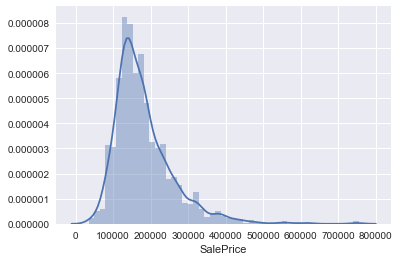

In [50]:
sales_price = train['SalePrice']
graph = sns.distplot(sales_price)

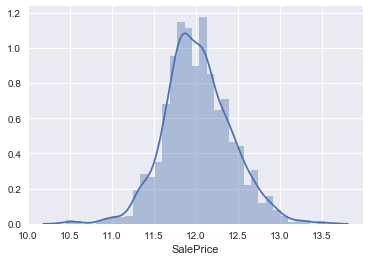

In [51]:
# Let's log-tranform this: 
sales_prices_log = np.log1p(sales_price)
graph = sns.distplot(sales_prices_log)

In [52]:
# Let's replace the SalePrice with the log-transformed version (will need to exponentiate predictions)
train['SalePrice'] = np.log1p(train['SalePrice'])

In [53]:
# Re-define the full dataset - and work on this until we are ready to split out test and train sets again
data_full = pd.concat([train, test], keys = ['train', 'test'])

In [54]:
# Let's see if any other features are skewed and replace these with log-transformed versions if so  
skewed_features = data_full[floats].apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[skewed_features > 0.75]
skewed_features

In [55]:
skewed_features = skewed_features.index
data_full[skewed_features] = np.log1p(data_full[skewed_features])

## Standardising numeric features

In [56]:
# Standardise numeric features (normalise)
numeric_features = data_full.loc[:,floats]
numeric_features_standardized = (numeric_features - numeric_features.mean())/numeric_features.std()
ax = sns.pairplot(numeric_features_standardized)

In [57]:
ax.savefig('charts_complete.png')

In [58]:
# Too many variables!  

### Split test-train sets again

In [59]:
# First, create dummy variables for categorical variables
dummy = pd.get_dummies(train)
# split out the test and train sets again
train = data_full.ix['train']
test = data_full.ix['test']

## Linear regression, backward elimination

In [60]:
# statsmodel requires all fieldsnames to begin with letters
train = train.rename(columns = {'1stFlrSF': 'FirstFlrSF','2ndFlrSF': 'SecondFlrSF','3SsnPorch': 'ThreeSsnPorch'})
test = test.rename(columns = {'1stFlrSF': 'FirstFlrSF','2ndFlrSF': 'SecondFlrSF','3SsnPorch': 'ThreeSsnPorch'})
data_full = pd.concat([train, test], keys = ['train', 'test'])

In [61]:
# this is the standard import if you're using "formula notation" (similar to R)
import statsmodels.formula.api as smf

# create a fitted model with all three features
lm = smf.ols(formula='SalePrice ~ LotFrontage + LotArea + MasVnrArea + BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF + TotalBsmtSF + FirstFlrSF + SecondFlrSF + LowQualFinSF + GrLivArea + GarageArea + WoodDeckSF + OpenPorchSF + EnclosedPorch + ThreeSsnPorch + ScreenPorch + PoolArea + MiscVal + OverallQual + OverallCond + BsmtFullBath + BsmtHalfBath + FullBath + BedroomAbvGr + KitchenAbvGr + TotRmsAbvGrd + Fireplaces', data=train).fit()

# print the coefficients
lm.summary()

In [62]:
# pick out some variables to drop
# plot charts for best predictors
# put back in the categorical variables?
# OpenPorchSF
# MiscVal
# BedroomAbvGr



In [63]:
p = lm.pvalues.sort(ascending = False, inplace=False)
p

## Collinearity
Let's check to see which predictors are correlated - many features are essentially the same thing.

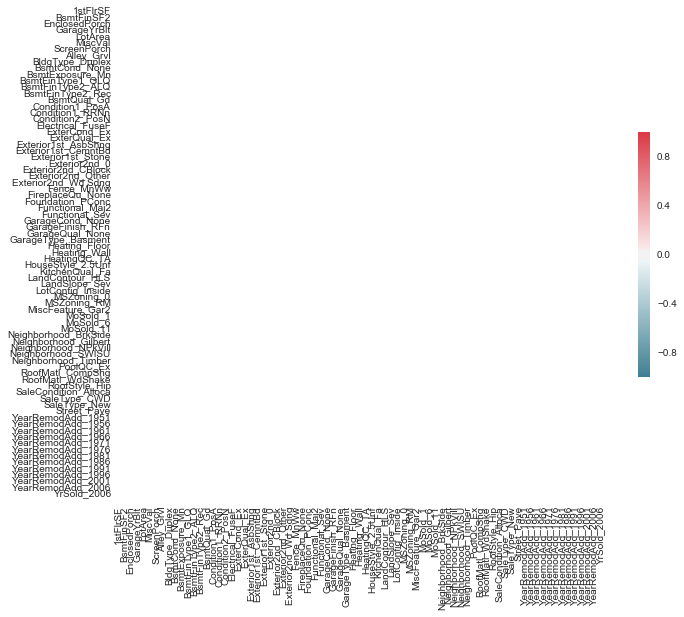

In [83]:
# Compute the correlation matrix
corr = data_full.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

# Simpler version (but too small to be useful)
# plt.matshow(data_full.corr())

Several predictors seem to be correlated, but the maximum correlation appears to be 0.4, so it's not worth removing these.

## Modelling: splitting the testing and training sets again

In [79]:
# Features - remove the thing we're trying to predict!
features = data_full.pop('SalePrice')

# Create dummy variables - for each categorical data, make several booleans
data_full = pd.get_dummies(data_full)

#creating matrices for sklearn:
X_train = features[:train.shape[0]]
X_test = features[train.shape[0]:]
# X_train = train
# X_test = test
y = train['SalePrice']

# Verify that the 
print(train.shape, X_train.shape)

(1460, 81) (1460,)


## Ridge regularisation (L2 regularisation)

In [66]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

In [71]:
# Define root-mean-square-error function - use 10-fold cross-validation
# You have to use neg_mean_squared_error because mean_squared_error will be deprecated in future
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return rmse
# Invoke Ridge regularisation
model_ridge = Ridge()

In [81]:
# Tune parameters - the only parameter is alpha - the larger alpha, the larger the penalty for extra predictors
alphas = [0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
# Work out the RMSE for each value of the alphas above: 
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)

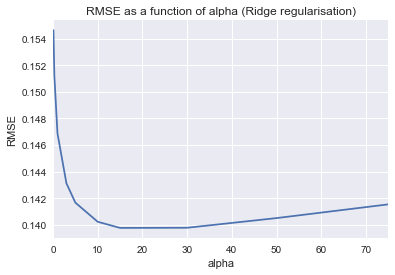

In [82]:
# Let's plot this
cv_ridge.plot(title = 'RMSE as a function of alpha (Ridge regularisation)')
plt.xlabel('alpha')
plt.ylabel('RMSE')

%%latex 
We want to chose the value of $\alpha$ that minimises the chart above. The extreme cases are $alpha = 0$, which corresponds to no penalty for each extra predictor, and $\alpha\to\inf$ which corresponds to a null model.  We want a balance between flexibility and over-fitting, which represents the minimium of this chart.

In [70]:
%%latex

UsageError: %%latex is a cell magic, but the cell body is empty.


In [ ]:
cv_ridge.min()

In [ ]:
#let's look at the residuals as well:
model_ridge = Ridge()
model_ridge(alpha = 10)
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_ridge.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

## Lasso regularisation (L1 regularisation)
The advantage of Lasso regularisation is that it performs some feature selection

In [ ]:
n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)
clf = Ridge(fit_intercept=False)

coefs = []
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X_train, y)
    coefs.append(clf.coef_)

In [ ]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
print(rmse_cv(model_lasso).mean())
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

In [ ]:
# trying to do the same thing is v inefficient ... takes forever ... what is going on?

In [ ]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [ ]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

# we need to bootstrap this and do it on a few random samples

In [ ]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [ ]:
# These look gash because we have not removed the skew